# Solar Orbiter 8 SPICE tutorial, 2022-09-16

[Éric Buchlin](mailto:eric.buchlin@universite-paris-saclay.fr).

A preliminary [data analysis user's manual](https://spice-wiki.ias.u-psud.fr/doku.php/data:data_analysis_manual) is available on the SPICE wiki.
This tutorial is based on Python, but IDL users can find IDL-specific information in this manual.


## Pre-requisites

* Up-to-date web browser
* Python with a recent version of the following libraries installed:
    * [sunpy](https://sunpy.org/).
    * [astropy](https://www.astropy.org/) (should be installed automatically as a sunpy dependency)
    * [sunpy-soar](https://github.com/dstansby/sunpy-soar)
    * [sunraster](https://github.com/sunpy/sunraster)
* A FITS file viewer: [SAOImageDS9](https://sites.google.com/cfa.harvard.edu/saoimageds9), [fv](https://heasarc.gsfc.nasa.gov/ftools/fv/)...

These imports should work with no error:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
import sunpy_soar
from astropy.io import fits
from sunpy.map import Map
from sunpy.net import Fido, attrs as a
from sunraster.instr.spice import read_spice_l2_fits

%matplotlib notebook
plt.rcParams["figure.figsize"] = (9, 8)  # larger default figure size

## SPICE data products overview

The data levels, FITS files, and headers are described in

* The [Data Products Description Document](https://spice.ias.u-psud.fr/spice-data/documents/SPICE-UIO-DPDD-0002-1.4-Data_Product_Description_Document.pdf) (DPDD)
* The LLDPDD for the Low-Latency (LL) files

The data levels:

* **L0**: Raw data
* **L1**: Engineering data (uncalibrated)
* **L2**: Science data (calibrated). This is the main data product you should use.
* **L3** (does not exist yet) – Higher level data: maps of fitted line parameters and of physical quantitites, images, movies.

A SPICE file name example is `solo_L2_spice-n-ras_20220302T181034_V04_100663690-000.fits`, where

* `L2` is the level
* `n-ras` is represents the product type:
    * **n-ras**: a raster scan with one of the narrow slits (2", 4" or 6")
    * **w-ras**: a raster scan with the wide slit (30")
    * **n-sit**: a sit-and-stare study with one of the narrow slits
    * **w-sit**: a sit-and-stare study with the wide slit
    * **n-exp**: a single exposure with a narrow slit that yields the entire spectrum
    * **w-exp**: a single exposure with the wide slit that yields the entire spectrum
* `20220302T181034` represents `DATE-BEG` (observation start) in UTC
* `V04` is the file version
* `100663690` is the observation ID (`SPIOBSID`)
* `000` is the index of the file (`RASTERNO`) for repeated observations within the same `SPIOBSID`:
    * For "ras" data, a FITS file contains a single raster scan (repeated exposures). If the raster is repeated, then each repeat goes in a new file.
    * For "exp" data, each exposure will end up in a different FITS file.

## Find data


### Using SOAR (web interface)

The primary source for SPICE data, as for all Solar Orbiter data, is the [Solar Orbiter Archive](http://soar.esac.esa.int/) (SOAR) at ESA.

SOAR provides a query form.

![SOAR screenshot](./fig/screenshot-soar-01.png)

SOAR has a TAP (Table Access Protocol) server (TAP is an IVOA protocol): click on the "programmatic access" icon in the left icon menu for details.
This TAP interface is used by the `sunpy_soar` Python module (developed by David Stansby), which provides SOAR access to SunPy [Fido](https://docs.sunpy.org/en/stable/guide/acquiring_data/fido.html) (Federated Internet Data Obtainer).

In [2]:
# Attributes allow us to specify the search parameters
results_spice = Fido.search(
    a.Time('2022-03-02T00:00', '2022-03-03T00:00'),
    a.soar.Product('SPICE-N-RAS'), # same as displayed in SODA: https://www.davidstansby.com/soda/
    a.Level(2)
    )
# Display tables of results
results_spice

Instrument,Data product,Level,Start time,End time,Data item ID,Filename,Filesize
,,,,,,,Mbyte
str5,str11,str2,str23,str23,str35,str58,float64
SPICE,SPICE-N-RAS,L2,2022-03-02 18:10:34.455,2022-03-02 23:31:14.485,solo_L2_spice-n-ras_20220302T181034,solo_L2_spice-n-ras_20220302T181034_V04_100663690-000.fits,377.047
SPICE,SPICE-N-RAS,L2,2022-03-02 09:10:34.648,2022-03-02 15:35:22.686,solo_L2_spice-n-ras_20220302T091034,solo_L2_spice-n-ras_20220302T091034_V03_100663686-000.fits,377.047
SPICE,SPICE-N-RAS,L2,2022-03-02 00:40:14.595,2022-03-02 07:05:02.633,solo_L2_spice-n-ras_20220302T004014,solo_L2_spice-n-ras_20220302T004014_V04_100663682-000.fits,377.047


### SPICE data releases

All released data are included in the [data releases](https://spice.osups.universite-paris-saclay.fr/spice-data/). The latest release ([currently 2.0](https://spice.osups.universite-paris-saclay.fr/spice-data/release-2.0/release-notes.html)) contains the latest version of each file, and is regularly updated with newly-available files.

The release used in a publication should be referenced as mentioned in the release notes (this also applies to data obtained from the SOAR), together with the whole SPICE dataset ([doi:10.5270/esa-lbmdy7c](https://doi.org/10.5270/esa-lbmdy7c)).

Each release contains a CSV table of all files in the release, which can be used to find specific SPICE observations:

In [3]:
def date_parser(string):
    try:
        return pd.Timestamp(string)
    except ValueError:
         return pd.NaT

date_columns = ['DATE-BEG','DATE', 'TIMAQUTC']
cat = pd.read_csv(
    'https://spice.osups.universite-paris-saclay.fr/spice-data/release-2.0/catalog.csv',
    date_parser=date_parser,
    parse_dates=date_columns
)

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (54,108,113) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# list of all columns
', '.join(cat.columns)

'FIRST_RASTER, NAXIS1, NAXIS2, NAXIS3, NAXIS4, OBT_BEG, LEVEL, FILENAME, DATE-BEG, SPIOBSID, RASTERNO, STUDYTYP, MISOSTUD, STUDYDES, STUDY, OBS_DESC, PURPOSE, XPOSURE, CNAME1, CRVAL1, CDELT1, CUNIT1, CTYPE1, CNAME2, CRVAL2, CDELT2, CUNIT2, CTYPE2, AUTHOR, STP, DSUN_AU, CROTA, OBS_ID, READMODE, SOOPNAME, SOOPTYPE, NRASTERS, STUDY_ID, XSTART, FOCUSPOS, NWIN, NWIN_PRF, NWIN_DUM, NWIN_INT, STUDYFLG, NOSPECTR, DBLEXP, DBLEXPNO, DARKMAP, BLACKLEV, CALMODE, COMPRESS, COMP_RAT, VERS_SW, VERS_CAL, VERSION, COMPLETE, SLIT_ID, SLIT_WID, DATE, TELAPSE, CREATOR, COMPTYPE, COMPPARA, SHCFFTID, VAR_KEYS, MIRRPOS, TN_FOCUS, TN_GRAT, TN_SW, TN_LW, T_FOCUS, T_GRAT, T_SW, T_LW, TIMAQUTC, VN_MCPSW, VN_MCPLW, VN_GAPSW, VN_GAPLW, V_MCPSW, V_MCPLW, V_GAPSW, V_GAPLW, PARENT, FILE_RAW, SOLAR_B0, SOLAR_P0, HGLT_OBS, HGLN_OBS, OBS_VR, PRSTEP1, PRPROC1, PRPVER1, PRPARA1, PRLIB1A, PRSTEP2, PRPROC2, PRPVER2, PRPARA2, PRLIB2A, PRSTEP3, PRPROC3, PRPVER3, PRPARA3, PRLIB3A, PRSTEP4, PRPROC4, PRPVER4, PRPARA4, PRLIB4A, P

In [5]:
display_cols = ['NAXIS1', 'NAXIS2', 'NAXIS3', 'NAXIS4', 'LEVEL', 'FILENAME', 'DATE-BEG']
cat[display_cols]

,NAXIS1,NAXIS2,NAXIS3,NAXIS4,LEVEL,FILENAME,DATE-BEG
0,1,1024,32,32,L1,solo_L1_spice-n-sit_20201117T035523_V11_335545...,2020-11-17 03:55:23.309
1,1,1024,1024,1,L1,solo_L1_spice-n-exp_20201117T040022_V06_335545...,2020-11-17 04:00:22.359
2,1,1024,1024,1,L1,solo_L1_spice-n-exp_20201117T040125_V11_335545...,2020-11-17 04:01:25.358
3,1,1024,1024,1,L1,solo_L1_spice-n-exp_20201117T040234_V11_335545...,2020-11-17 04:02:34.360
4,1,1024,1024,1,L1,solo_L1_spice-n-exp_20201117T040346_V11_335545...,2020-11-17 04:03:46.960
...,...,...,...,...,...,...,...
13960,1,1024,1024,1,L2,solo_L2_spice-n-exp_20220405T233823_V02_100664...,2022-04-05 23:38:23.151
13961,1,1024,1024,1,L2,solo_L2_spice-n-exp_20220405T234008_V02_100664...,2022-04-05 23:40:08.051
13962,1,1024,1024,1,L2,solo_L2_spice-n-exp_20220405T234154_V02_100664...,2022-04-05 23:41:54.201
13963,1,1024,1024,1,L2,solo_L2_spice-n-exp_20220405T234340_V02_100664...,2022-04-05 23:43:40.052


In [6]:
# search according to some criteria
spice_cat = cat[
    (cat.LEVEL == 'L2') &
    (cat['DATE-BEG'] > pd.Timestamp('2022-03-02T00:00')) &
    (cat['DATE-BEG'] < pd.Timestamp('2022-03-03T00:00')) &
    (cat.STUDYTYP == 'Raster')  # rasters
]
spice_cat[display_cols]

,NAXIS1,NAXIS2,NAXIS3,NAXIS4,LEVEL,FILENAME,DATE-BEG
8831,192,834,80,1,L2,solo_L2_spice-n-ras_20220302T004014_V04_100663...,2022-03-02 00:40:14.595
8893,192,834,80,1,L2,solo_L2_spice-n-ras_20220302T091034_V03_100663...,2022-03-02 09:10:34.648
8955,192,834,80,1,L2,solo_L2_spice-n-ras_20220302T181034_V04_100663...,2022-03-02 18:10:34.455


## Download files from SOAR

Taking the result of `Fido.search()` above, we can download them (here we select only the first file, from the first (and only) provider):

In [7]:
spice_files = Fido.fetch(results_spice[0][0], path="data/{file}")
# In case you have already downloaded the file before the tutorial
# spice_files = ['data/solo_L2_spice-n-ras_20220302T181034_V04_100663690-000.fits']
print(spice_files)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['data/solo_L2_spice-n-ras_20220302T181034_V04_100663690-000.fits']


## Open FITS files

As SO remote-sensing instruments data files are regular FITS files, they can normally be opended using any FITS library, in any language. For example, here we open the downloaded SPICE file with [`astropy.io.fits`](https://docs.astropy.org/en/stable/io/fits/index.html):

In [8]:
hdulist = fits.open(spice_files[0])
hdulist.info()

Filename: data/solo_L2_spice-n-ras_20220302T181034_V04_100663690-000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  O III 703 / Mg IX 706 - SH    1 PrimaryHDU     358   (192, 834, 80, 1)   float32   
  1  O III 703 / Mg IX 706 - LH    1 ImageHDU       359   (192, 834, 80, 1)   float32   
  2  S IV 750/ Mg IX (spectral bin 2)    1 ImageHDU       363   (192, 834, 32, 1)   float32   
  3  N IV 765 - Peak    1 ImageHDU       357   (192, 834, 25, 1)   float32   
  4  Ne VIII 770 / Mg VIII 772 - SH    1 ImageHDU       363   (192, 834, 41, 1)   float32   
  5  Ne VIII 770 / Mg VIII 772 - LH    1 ImageHDU       363   (192, 834, 41, 1)   float32   
  6  S V 786 / O IV 787 - Extend    1 ImageHDU       359   (192, 834, 58, 1)   float32   
  7  S IV 748 - Extended    1 ImageHDU       363   (192, 834, 32, 1)   float32   
  8  S V 786 / O IV 787 - LW    1 ImageHDU       359   (192, 834, 58, 1)   float32   
  9  N III 991 - SH    1 ImageHDU       359   (192, 834, 62, 1)   flo

In [9]:
# Print first HDU (Header-Data Unit) header, including global and window-specific metadata:
hdulist[0].header

SIMPLE  =                    T / Written by IDL:  Wed May 25 09:28:29 2022      
BITPIX  =                  -32 / Real*4 (floating point)                        
NAXIS   =                    4 / Number of dimensions                           
NAXIS1  =                  192 / Number of slit positions (x)                   
NAXIS2  =                  834 / Number of pixels along slit (y)                
NAXIS3  =                   80 / Number of pixels in dispersion dimension       
NAXIS4  =                    1 / Number of exposures per slit position (time)   
EXTEND  =                    T /  FITS dataset may contain extensions           
DATE    = '2022-05-25T09:28:29' / Date and time of FITS file creation           
                                                                                
EXTNAME = 'O III 703 / Mg IX 706 - SH' / Extension name                         
FILENAME= 'solo_L2_spice-n-ras_20220302T181034_V04_100663690-000.fits' / Filenam
                            

In [10]:
# And the corresponding data type and shape:
data = hdulist[0].data
type(data), data.shape

(numpy.ndarray, (1, 80, 834, 192))

These axes dimensions correspond the the `NAXIS*` metadata in reverse order:
```
NAXIS1  =                  192 / Number of slit positions (x)
NAXIS2  =                  834 / Number of pixels along slit (y)
NAXIS3  =                   80 / Number of pixels in dispersion dimension
NAXIS4  =                    1 / Number of exposures per slit position (time)
```

So L2 files can be analysed using this FITS object, but as maps with the `Map` object of `sunpy.map`, it can be more convenient to use the `SpectrogramCube` object from [`sunraster`](https://docs.sunpy.org/projects/sunraster/en/latest/) (developed as a generalization of IRIS software, for any spectrogram data).

`sunraster` includes a SPICE file reader:

In [11]:
from sunraster.instr.spice import read_spice_l2_fits
raster = read_spice_l2_fits(spice_files[0])

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 59640.757343 from DATE-OBS.
Set MJD-BEG to 59640.757343 from DATE-BEG.
Set MJD-AVG to 59640.868686 from DATE-AVG.
Set MJD-END to 59640.980026 from DATE-END'. [astropy.wcs.wcs]


In [12]:
raster

NDCollection
------------
Cube keys: ('O III 703 / Mg IX 706 - SH', 'O III 703 / Mg IX 706 - LH', 'S IV 750/ Mg IX (spectral bin 2)', 'N IV 765 - Peak', 'Ne VIII 770 / Mg VIII 772 - SH', 'Ne VIII 770 / Mg VIII 772 - LH', 'S V 786 / O IV 787 - Extend', 'S IV 748 - Extended', 'S V 786 / O IV 787 - LW', 'N III 991 - SH', 'N III 991 - LH', 'O VI 1032 - Peak')
Number of Cubes: 12
Aligned dimensions: [1.0 834.0 192.0] pix
Aligned physical types: [('time',), ('custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon'), ('custom:pos.helioprojective.lat', 'time', 'custom:pos.helioprojective.lon')]

Keys correspond to the names of the wavelength windows on the detector. 

In case of a full-detector (non-windowed) study, they are the names of the detectors, with SW for short-wavelength and LW for long-wavelength.

One can select such a window:

In [13]:
window = raster['Ne VIII 770 / Mg VIII 772 - SH']
window

SpectrogramCube
---------------
Time Period: ['2022-03-02 18:11:34.455' '2022-03-03 00:34:22.205']
Instrument axes: ['raster scan' 'spectral' 'slit' 'slit step']
Pixel dimensions: [  1  41 834 192] pix
Longitude range: [-714.19366816   71.12177218] arcsec
Latitude range: [-1145.85118004  -213.49467333] arcsec
Spectral range: [7.67392826e-08 7.75194186e-08] m
Data unit: adu

In this case, "SH" means "short-wavelength half of the line". This is because the maximum width of SPICE spectral windows is 32 pixels on the detector, and this is most of the times not enough (all the more that we try here to catch both Ne VIII 77.0nm and Mg VIII 77.2nm). Then several adjacent windows can be used, in this case they are labelled "SH" and "LH".

However, both windows are merged in the L2 FITS files, so the content of 'Ne VIII 770 / Mg VIII 772 - SH' and 'Ne VIII 770 / Mg VIII 772 - LH' is actually the same.

In [14]:
# As we have already seen, the 4 dimensions are (t, λ, y, x). This is the Python order, reversed from the FITS or IDL order.
window.instrument_axes

array(['raster scan', 'spectral', 'slit', 'slit step'], dtype='<U11')

In [15]:
# Coordinates are known in WCS (World Coordinate System)
window.wcs

WCS Keywords

Number of WCS axes: 4
CTYPE : 'HPLN-TAN'  'HPLT-TAN'  'WAVE'  'TIME'  
CRVAL : -0.0893147601363889  -0.18879834080722221  7.71293506e-08  11543.875  
CRPIX : 96.5  417.5  21.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 0.999723070447  0.00645969376502  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : -0.0857288962547  0.999723070447  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : -120.25  0.0  0.0  1.0  
CDELT : 0.0011111111111111111  0.00030500000000000004  1.9503400000000002e-11  1.0  
NAXIS : 192  834  41  1

In [16]:
# For better image value normalization
from astropy.visualization import SqrtStretch, AsymmetricPercentileInterval, ImageNormalize
norm = ImageNormalize(window.data,
                      interval=AsymmetricPercentileInterval(1, 99),
                      stretch=SqrtStretch()
                     )

<IPython.core.display.Javascript object>


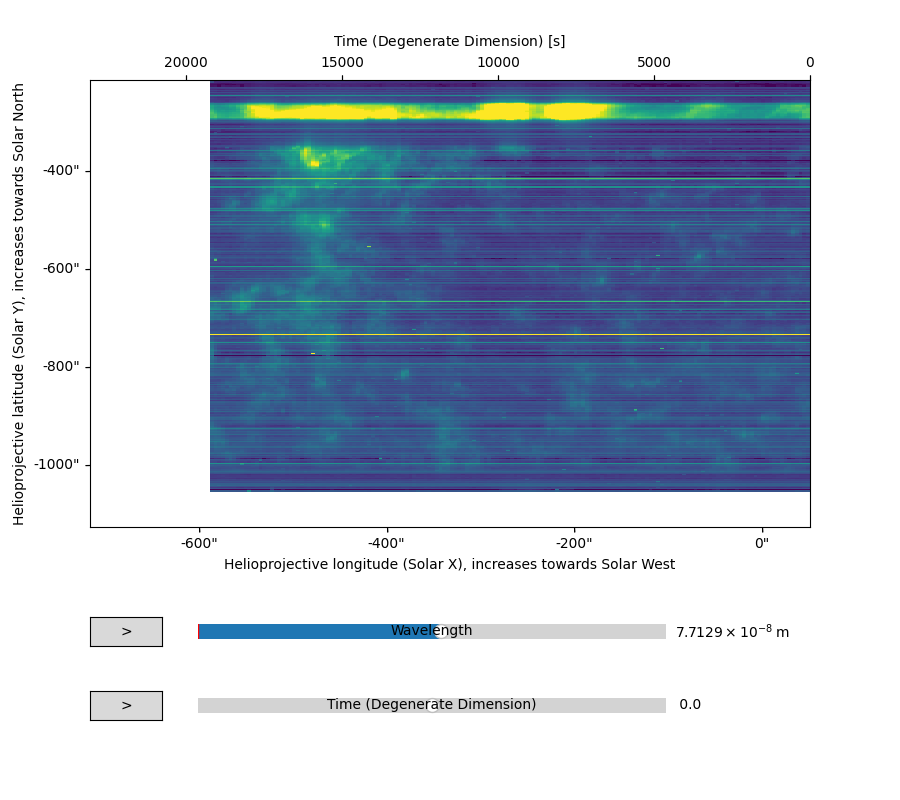

/home/eric/.local/lib/python3.10/site-packages/mpl_animators/base.py:352: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  sframe = widgets.Slider(self.sliders[-1], "",


In [17]:
# Show (x, y) cut in cube, at some λ that can be chosen by a slider
# Please change λ, otherwise the map will stay blank (NaN / no data)
# Note: an IDL quicklook tool exists, a Python tools are in development
window.plot(norm=norm, aspect='auto')

The bright line at the top corresponds to the bright "dumbbell", a wider part of the slit, meant to help co-alignement with imaging data.

The other horizontal lines are instrumental effects that should have been corrected.

In [18]:
# select some central wavelength, giving a 2D (x, y) map
window_peak = window[0, 12, :, :]

In [19]:
window_peak

SpectrogramCube
---------------
Time Period: ['2022-03-02 18:11:34.455' '2022-03-03 00:34:22.205']
Instrument axes: ['slit' 'slit step']
Pixel dimensions: [834 192] pix
Longitude range: [-714.19366816   71.12177218] arcsec
Latitude range: [-1145.85118004  -213.49467333] arcsec
Spectral range: None
Data unit: adu

<IPython.core.display.Javascript object>


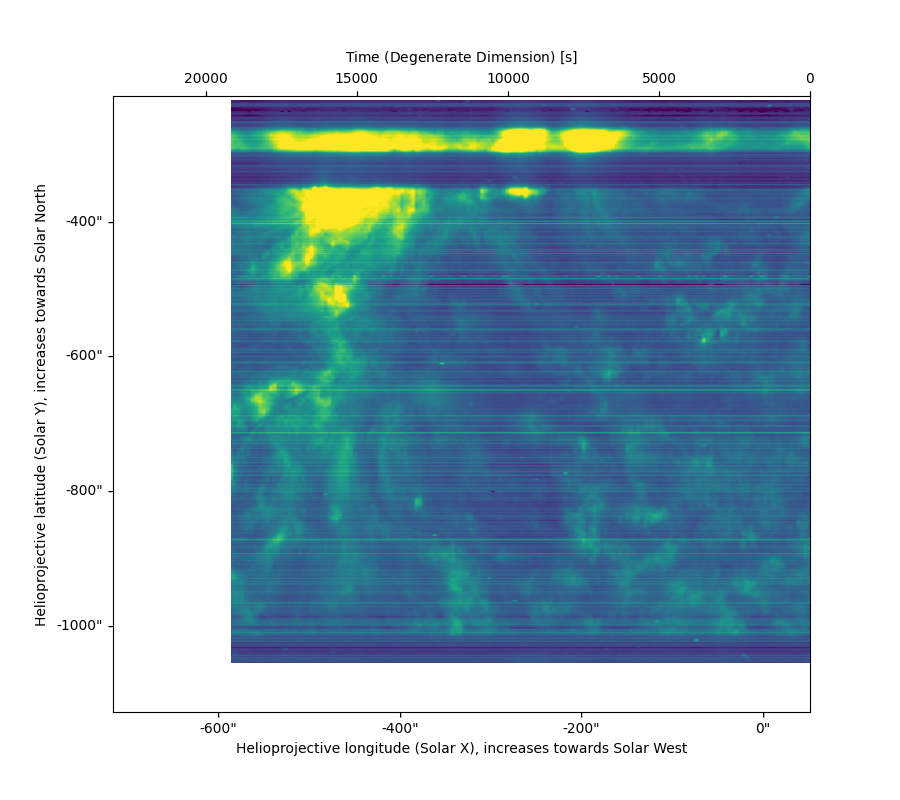

<WCSAxesSubplot:>

In [20]:
plt.figure()
window_peak.plot(norm=norm, aspect='auto')

In [21]:
# An alternative is to make a sunpy Map out of the data and metadata
m_spice = Map((window_peak.data, window_peak.meta))
m_spice.plot_settings['cmap'] = plt.get_cmap('viridis')
m_spice.plot_settings['norm'] = norm

<IPython.core.display.Javascript object>


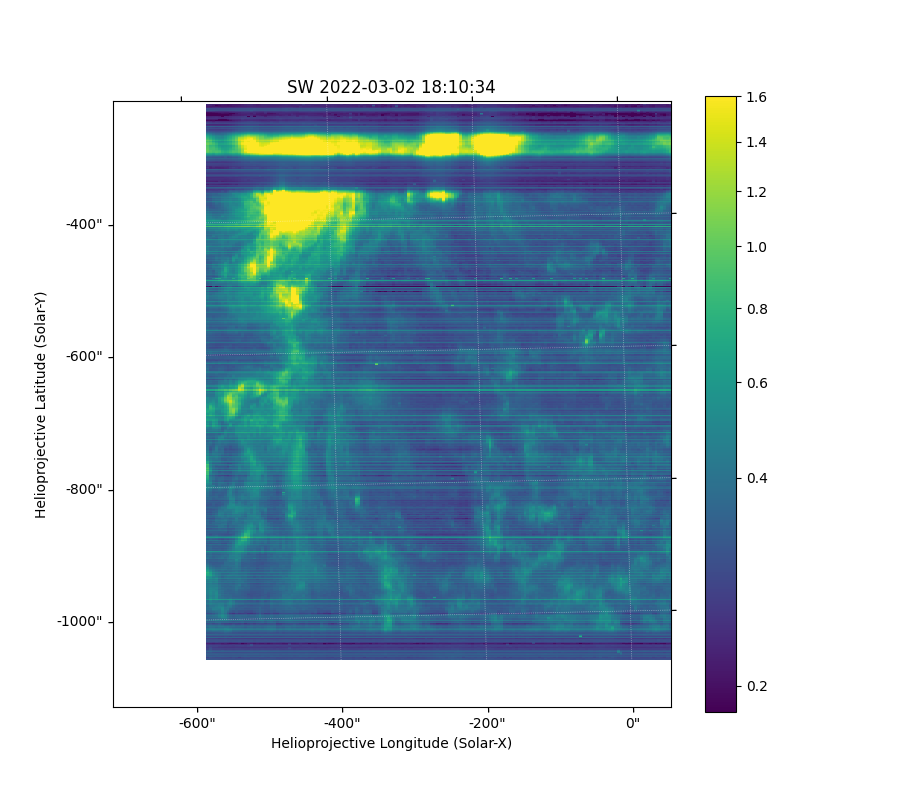

In [22]:
plt.figure()
m_spice.plot(norm=norm, aspect=1/4)  # 1/4 because raster step is 4", about 4 times the vertical pixel size 
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


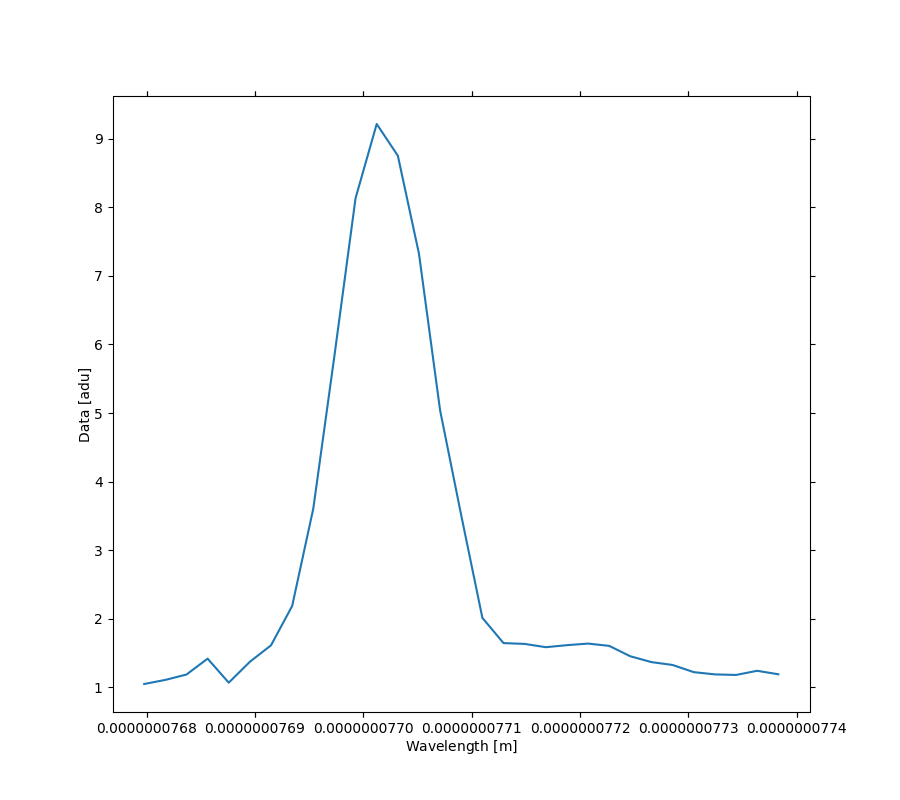

<WCSAxesSubplot:ylabel='Data [adu]'>

In [23]:
# Display the spectrum at some pixel
plt.figure()
window[0, :, 674, 60].plot()

We won't dive into line fitting, but here are some libraries that can be used:

* [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html)
* [`astropy.modeling`](https://docs.astropy.org/en/stable/modeling/index.html)
* Line fitting software adapted specifically to SPICE data is in development at GSFC. 

Then fitted models parameters can give line radiance, Doppler shift, line width... and allow separation of several lines, or blended lines.

**There is currently still an issue with SPICE Doppler maps, please contact us before interpreting what you see in them**.

<IPython.core.display.Javascript object>


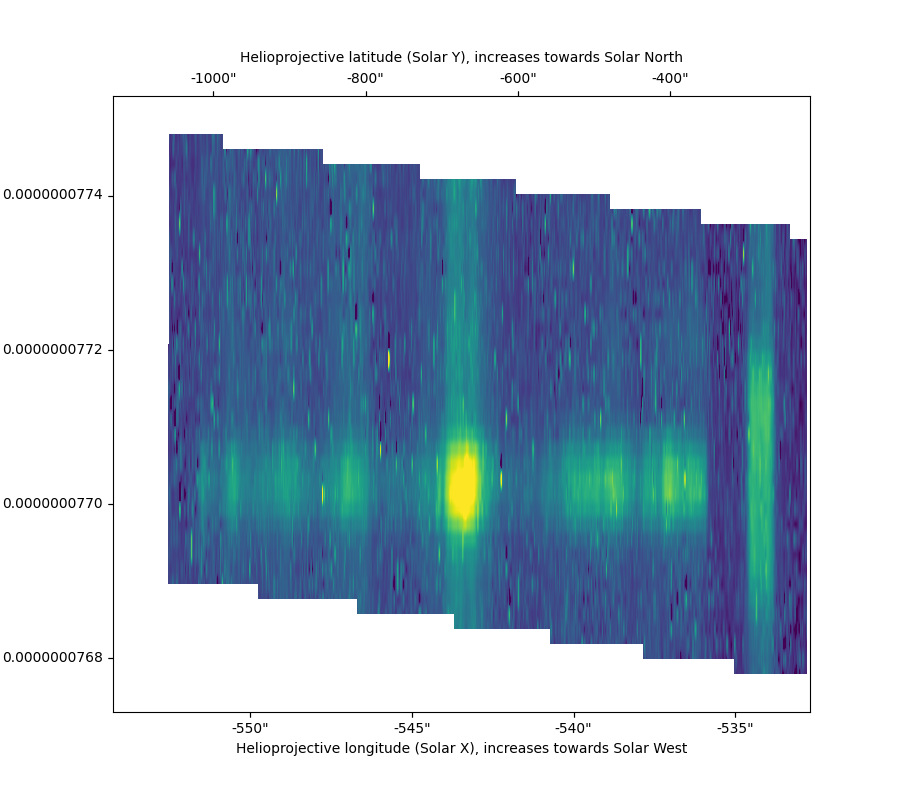

<WCSAxesSubplot:>

In [24]:
# Select and display a raster position, giving a (y, λ) detector view (but with distortion already corrected)
window_detector = window[0, :, :, 40]
plt.figure()
window_detector.plot(norm=norm, aspect='auto')

## Bonus: overplotting SPICE map on an EUI submap

In [25]:
# SPICE average raster time time
from astropy.time import Time, TimeDelta
t = raster['Ne VIII 770 / Mg VIII 772 - SH'].time
t_av = Time(t.jd.mean(), format='jd', scale='utc')
t_av.to_value('iso')

'2022-03-02 21:22:58.330'

In [26]:
# Find corresponding FSI 17.4nm image
delta_t = TimeDelta(20 * 60, format='sec')
results_fsi = Fido.search(
    a.Time(t_av - delta_t, t_av + delta_t),
    a.soar.Product('EUI-FSI174-IMAGE'), # same as displayed in SODA
    a.Level(2)
    )
# Display tables of results
results_fsi

Instrument,Data product,Level,Start time,End time,Data item ID,Filename,Filesize
,,,,,,,Mbyte
str3,str16,str2,str23,str23,str43,str52,float64
EUI,EUI-FSI174-IMAGE,L2,2022-03-02 21:30:17.344,2022-03-02 21:30:27.344,solo_L2_eui-fsi174-image_20220302T213017344,solo_L2_eui-fsi174-image_20220302T213017344_V01.fits,3.338
EUI,EUI-FSI174-IMAGE,L2,2022-03-02 21:15:17.695,2022-03-02 21:15:27.695,solo_L2_eui-fsi174-image_20220302T211517695,solo_L2_eui-fsi174-image_20220302T211517695_V01.fits,3.358


In [27]:
# Download first file (if not already done)
fsi_files = Fido.fetch(results_fsi[0][0], path="data/{file}")
print(fsi_files)
# In case you have already downloaded the file before the tutorial, you can replace the download by:
# fsi_files = ['data/solo_L2_eui-fsi174-image_20220302T173017304_V01.fits']

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['data/solo_L2_eui-fsi174-image_20220302T213017344_V01.fits']


Plot the map:

In [28]:
# Plot a composite EUI/FSI + SPICE map
from astropy.coordinates import SkyCoord

m_fsi = Map(fsi_files[0])
bottom_left = SkyCoord(-1000 * u.arcsec, -1500 * u.arcsec, frame=m_fsi.coordinate_frame)
top_right = SkyCoord(500 * u.arcsec, 0 * u.arcsec, frame=m_fsi.coordinate_frame)
sm_fsi = m_fsi.submap(bottom_left=bottom_left, top_right=top_right)

<IPython.core.display.Javascript object>


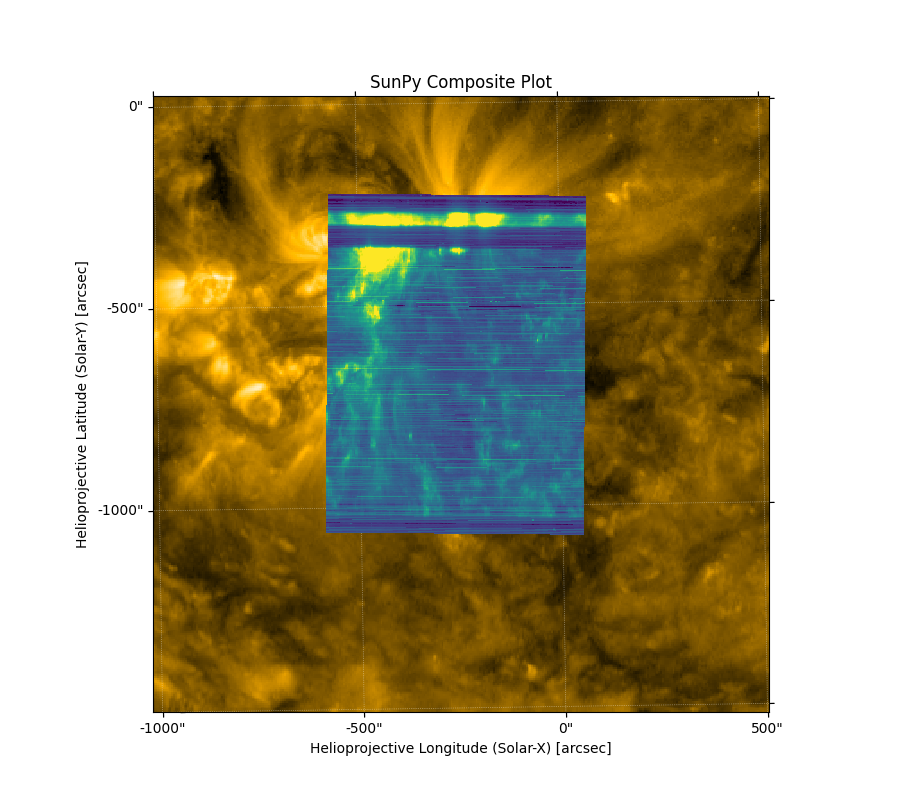

In [29]:
# Using a CompositeMap
comp_map = Map(sm_fsi, m_spice, composite=True)
plt.figure()
comp_map.plot()
plt.show()

# Simply plotting both maps with proper alignment
#sm_fsi.plot()
#m_spice.plot(autoalign=True)